In [126]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 06: Base Model Descriptives
 * Compare the results for Friedman's H, ALE, and Shapley.  
 * Get some descriptive plots relating to term and interest rate

*This script takes about 1 minutes on my MacBook Air*

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import sklearn as sk
import matplotlib as mpl
import warnings
import time
import scipy
import random
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
import scipy.sparse as sp
from sklearn.inspection import partial_dependence

In [128]:
setup.plot_defaults()

## Import Data

##### Predictors

In [129]:
predictor_features = pd.read_csv(Path(setup.temp_path) \
                                 .joinpath('01_REPORT_predictor_features.csv'))['feature'].tolist()

##### Dataset - use sample of training data

In [130]:
train_samp_df = pd.read_parquet(Path(setup.temp_path) \
                                .joinpath('03_DATA_combined_base_train_samp.parquet')) 

##### Model

In [131]:
with open(Path(setup.temp_path).joinpath('02_MODEL_base_gc.pkl'), 'rb') as pi:
    base_model = pickle.load(pi)

##### Permutation importances

In [132]:
perm_importance_df = pd.read_csv(Path(setup.temp_path).joinpath('02_DATA_importance_perturb.csv'))

##### Friedman's H Scores

In [133]:
h_comb = pd.read_csv(Path(setup.temp_path).joinpath('03_DATA_h_scores.csv'))

##### 2-Way ALE Mean Abs

In [134]:
ale_mean_abs = pd.read_csv(Path(setup.temp_path).joinpath('04_DATA_ale_magnitudes_2way.csv'))

##### Shapley Interaction Mean Abs

In [135]:
shap_mean_abs = pd.read_csv(Path(setup.temp_path).joinpath('05_DATA_shap_mean_abs.csv'))

## Compare Ranks for the Three Methods

##### Align ranks and save table

In [136]:
h_comb['rank'] = h_comb['h_score'].rank(method='first', ascending=False) 
h_comb = h_comb.rename(columns={'h_score':'score'})

In [137]:
ale_mean_abs['rank'] = ale_mean_abs['abs_mean'].rank(method='first', ascending=False)
ale_mean_abs = ale_mean_abs.rename(columns={'abs_mean':'score'})

In [138]:
shap_mean_abs_int = shap_mean_abs[shap_mean_abs['feat_1'] != shap_mean_abs['feat_2']] \
    .copy() \
    .rename(columns={'shap_mean_abs':'score'})
shap_mean_abs_int['rank'] = shap_mean_abs_int['score'].rank(method='first', ascending=False)

In [139]:
rank_comb = h_comb[['rank', 'score', 'label']] \
    .merge(ale_mean_abs[['rank', 'score', 'label']], how='outer', on='rank',
           suffixes=('_h', '_ale')) \
    .merge(shap_mean_abs_int[['rank', 'score', 'label']], how='outer', on='rank') \
    .rename(columns={'score':'score_shap', 'label':'label_shap'})

In [140]:
rank_comb.head()

,rank,score_h,label_h,score_ale,label_ale,score_shap,label_shap
0,1.0,0.234603,loan_amnt:revol_bal,0.012337,loan_amnt:annual_inc,0.028876,int_rate:term
1,2.0,0.178645,revol_bal:verification_status,0.012336,int_rate:term,0.018142,int_rate:loan_amnt
2,3.0,0.171378,loan_amnt:annual_inc,0.011016,int_rate:annual_inc,0.017496,int_rate:sec_app_fico_range_low
3,4.0,0.169135,num_actv_bc_tl:revol_bal,0.010569,loan_amnt:open_acc,0.012363,int_rate:annual_inc
4,5.0,0.128730,home_ownership__RENT:num_actv_bc_tl,0.010504,int_rate:loan_amnt,0.010590,int_rate:mort_acc


In [141]:
rank_comb.to_csv(Path(setup.temp_path).joinpath('06_REPORT_top_interactions_all.csv'),
                   index=False)

##### Correlations among ranks and with perturbation importances

In [142]:
# Merge ranked data by feature

In [143]:
comb_score_by_feature = h_comb[['rank', 'score', 'label', 'feat_1', 'feat_2']] \
    .merge(ale_mean_abs[['rank', 'score', 'feat_1', 'feat_2']], how='outer', 
           on=['feat_1', 'feat_2'],suffixes=('_h', '_ale')) \
    .merge(shap_mean_abs_int[['rank', 'score', 'feat_1', 'feat_2']], how='outer', 
           on=['feat_1', 'feat_2']) \
    .rename(columns={'score':'score_shap', 'rank':'rank_shap'})

In [144]:
# Append permutation feature importances
comb_score_by_feature = comb_score_by_feature.merge(perm_importance_df[['features', 'abs_importance']] \
                                      .rename(columns={'abs_importance':'pi_1_a'}),
                                  how='left', left_on='feat_1', right_on='features') \
    .drop(columns=['features']) \
    .merge(perm_importance_df[['features', 'abs_importance']] \
                                      .rename(columns={'abs_importance':'pi_2_a'}),
                                  how='left', left_on='feat_2', right_on='features') \
    .drop(columns=['features']) 

In [145]:
# Reorder permutation importances by strength
comb_score_by_feature['pi_1'] = np.where(comb_score_by_feature['pi_1_a'] >=  comb_score_by_feature['pi_2_a'],
                                   comb_score_by_feature['pi_1_a'], comb_score_by_feature['pi_2_a'])
comb_score_by_feature['pi_2'] = np.where(comb_score_by_feature['pi_1_a'] >=  comb_score_by_feature['pi_2_a'],
                                   comb_score_by_feature['pi_2_a'], comb_score_by_feature['pi_1_a'])
comb_score_by_feature.drop(columns=['pi_1_a', 'pi_2_a'], inplace=True)

In [146]:
comb_score_by_feature.sort_values('rank_ale').head()

,rank_h,score_h,label,feat_1,feat_2,rank_ale,score_ale,rank_shap,score_shap,pi_1,pi_2
2,3.0,0.171378,loan_amnt:annual_inc,loan_amnt,annual_inc,1.0,0.012337,8.0,0.008784,0.001010,0.000983
8,9.0,0.101609,int_rate:term,int_rate,term,2.0,0.012336,1.0,0.028876,0.003413,0.001203
33,34.0,0.041471,int_rate:annual_inc,int_rate,annual_inc,3.0,0.011016,4.0,0.012363,0.003413,0.000983
13,14.0,0.087122,loan_amnt:open_acc,loan_amnt,open_acc,4.0,0.010569,46.0,0.002913,0.001010,0.000356
18,19.0,0.074452,int_rate:loan_amnt,int_rate,loan_amnt,5.0,0.010504,2.0,0.018142,0.003413,0.001010


In [147]:
# Correlations
comb_score_corr  = comb_score_by_feature[['score_h', 'score_ale', 'score_shap', 'pi_1', 'pi_2']].corr(method='spearman')

In [148]:
comb_score_corr

,score_h,score_ale,score_shap,pi_1,pi_2
score_h,1.000000,0.137286,0.347036,-0.334086,-0.032902
score_ale,0.137286,1.000000,0.603821,0.491272,0.684690
score_shap,0.347036,0.603821,1.000000,0.544495,0.762971
pi_1,-0.334086,0.491272,0.544495,1.000000,0.467320
pi_2,-0.032902,0.684690,0.762971,0.467320,1.000000


In [149]:
comb_score_corr.to_csv(Path(setup.temp_path).joinpath('06_REPORT_interactions_corr.csv'),
                   index=True)

## Term and Interest Rate
This is an interaction which shows opposite yet similar effects with SHAP vs. ALE.  Get more information about these features and how the model responds to them.

### Correlations between term and other features

In [150]:
term_corr = pd.DataFrame({'feature': predictor_features,
                          'corr': [train_samp_df[['term', f]] \
                                   .corr().iloc[0,1] for f in predictor_features]})

In [151]:
term_corr.sort_values('corr', ascending=False).head(5)

,feature,corr
1,term,1.000000
2,int_rate,0.420609
0,loan_amnt,0.378657
5,verification_status,0.130195
9,initial_list_status,0.101052


## Correlations between interest rate and other features

In [152]:
int_rate_corr = pd.DataFrame({'feature': predictor_features,
                          'corr': [train_samp_df[['int_rate', f]] \
                                   .corr().iloc[0,1] for f in predictor_features]})

In [153]:
int_rate_corr.sort_values('corr', ascending=False).head(5)

,feature,corr
2,int_rate,1.000000
1,term,0.420609
5,verification_status,0.221517
0,loan_amnt,0.139630
15,home_ownership__RENT,0.072318


In [154]:
train_samp_df['int_rate'].describe()

count    100000.000000
mean         13.245706
std           4.776438
min           5.310000
25%           9.750000
50%          12.740000
75%          15.990000
max          30.990000
Name: int_rate, dtype: float64

In [155]:
train_samp_df['term'].value_counts(normalize=True)

36    0.75712
60    0.24288
Name: term, dtype: float64

## Comparisons of high- vs. low-interest rate cases

In [156]:
train_samp_df['high_int'] = np.where(train_samp_df['int_rate'] > 20, 1, 0)

In [157]:
train_samp_df['high_int'].value_counts(normalize=True)

0    0.92027
1    0.07973
Name: high_int, dtype: float64

In [158]:
pd.crosstab(train_samp_df['high_int'], train_samp_df['grade'], normalize='index')

grade,A,B,C,D,E,F,G
high_int,,,,,,,
0,0.191031,0.315451,0.310387,0.152205,0.030535,0.000391,0.000000
1,0.000000,0.000000,0.000000,0.102596,0.516368,0.291609,0.089427


In [159]:
pd.crosstab(train_samp_df['high_int'], train_samp_df['verification_status'],
           normalize='index')

verification_status,0,1
high_int,,
0,0.318417,0.681583
1,0.120156,0.879844


In [160]:
pd.crosstab(train_samp_df['high_int'], train_samp_df['home_ownership__RENT'],
           normalize='index')

home_ownership__RENT,0,1
high_int,,
0,0.607191,0.392809
1,0.570801,0.429199


In [161]:
pd.crosstab(train_samp_df['high_int'], train_samp_df['purpose'],
           normalize='index')

purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
high_int,,,,,,,,,,,,,,
0,0.011149,0.23103,0.574657,0.000272,0.066915,0.004683,0.021613,0.010899,0.006585,0.053636,0.000587,0.009519,0.006770,0.001684
1,0.009030,0.10222,0.640411,0.000000,0.062210,0.011414,0.018939,0.015427,0.011915,0.092186,0.001881,0.026464,0.005644,0.002258


In [163]:
train_samp_df.groupby('high_int') \
    [['fico_range_low', 'sec_app_fico_range_low', 'loan_amnt', 'emp_length', 
     'annual_inc']] \
    .agg('mean')

,fico_range_low,sec_app_fico_range_low,loan_amnt,emp_length,annual_inc
high_int,,,,,
0,697.418312,696.862769,14120.901475,5.609310,76785.952010
1,681.557757,680.491032,18220.111627,5.716042,73200.382882


### 2-Way plots of actual and predicted rates.
What does the raw data / response show?  Bucket the interest rates and plot the mean term rates / model response for both term values.

In [30]:
# Get model predictions
model_predict = pd.Series(base_model.predict_proba(train_samp_df[predictor_features])[:,1])
model_predict.name = 'predict'

In [31]:
# Append to data
train_pred_df = pd.concat([train_samp_df[['int_rate', 'term', 'target']].reset_index(), 
                           model_predict], axis=1)

In [32]:
# Bucket the interest rates
train_pred_df['int_rate_grp'] = pd.qcut(train_pred_df['int_rate'], 25, duplicates='drop')

In [33]:
# Aggregate
train_samp_agg = train_pred_df.groupby(['int_rate_grp', 'term']) \
    [['target', 'predict']] \
    .agg(['mean', 'std']) 
train_samp_agg.columns = [c[0]+'_' + c[1] for c in train_samp_agg.columns]
train_samp_agg.reset_index(inplace=True)

In [34]:
# Add interest rate midpoints for plotting
train_samp_agg['plot_x'] = train_samp_agg['int_rate_grp'].apply(lambda x: float(x.mid))

In [35]:
train_samp_agg_plot = train_samp_agg[['plot_x', 'term', 'target_mean', 'predict_mean']] \
    .pivot(index='plot_x', columns='term', values=['target_mean', 'predict_mean'])

In [36]:
# Colors array for plot
cmap = mpl.cm.coolwarm
n = len(train_samp_agg['term'].value_counts())
colors = cmap(np.linspace(0,1,n))


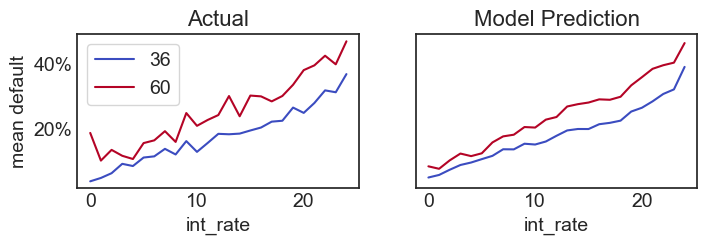

In [37]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
figsize=(8,2)
    
train_samp_agg_plot[[c for c in train_samp_agg_plot.columns if c[0] == 'target_mean']] \
    .droplevel(0, axis=1) \
    .plot(color=colors, legend=None, figsize=figsize, ax=ax[0])
train_samp_agg_plot[[c for c in train_samp_agg_plot.columns if c[0] == 'predict_mean']] \
    .droplevel(0, axis=1) \
    .plot(color=colors, legend=None, figsize=figsize, ax=ax[1])     

ax[0].legend(frameon=True)
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax[1].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax[1].set_xlabel('int_rate')
ax[0].set_xlabel('int_rate')
ax[0].set_ylabel('mean default')
ax[0].title.set_text('Actual')
ax[1].title.set_text('Model Prediction')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_actual_pred.png'),
            bbox_inches='tight')

## PDP / ICE Plots - Term and Interest Rate

##### 2-Way PDP Average

In [38]:
# Get 2-Way PDP
avg_pdp = partial_dependence(base_model, train_samp_df[predictor_features], 
                                  ['int_rate', 'term'], kind='average',
                             percentiles=(0,1),
                            method='brute')

In [39]:
# Convert to data frame
avg_pdp_df = pd.concat([pd.DataFrame(avg_pdp['values'][0], columns=['values']),
                         pd.DataFrame(avg_pdp['average'][0], columns=avg_pdp['values'][1])],
                        axis=1)

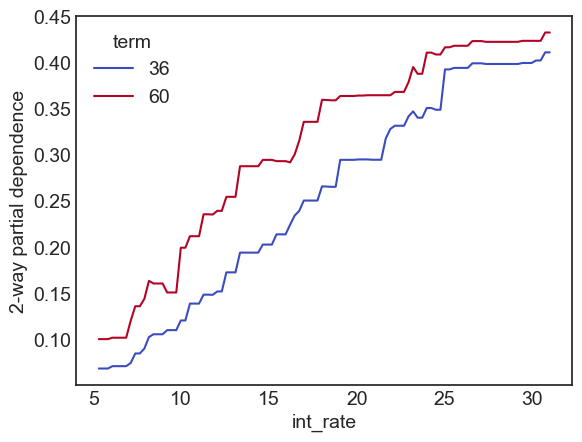

In [40]:
# Plot
fig, ax = plt.subplots()
avg_pdp_df.set_index('values').plot(color = colors, ax=ax)
ax.set_ylabel('2-way partial dependence')
ax.set_xlabel('int_rate')
ax.legend(title='term')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_pdp_avg.png'),
            bbox_inches='tight')

##### Overlay 1-Way Averages

In [41]:
term_value_counts = train_samp_df['term'].value_counts()
color_categories = term_value_counts.index
cnorm  = mpl.colors.Normalize(vmin=0, vmax= len(color_categories) - 1)
color_scalar_map = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
color_dict = {color_categories[i]: color_scalar_map.to_rgba(i) 
              for i in range(0, len(color_categories))}

In [42]:
len(term_value_counts)

2

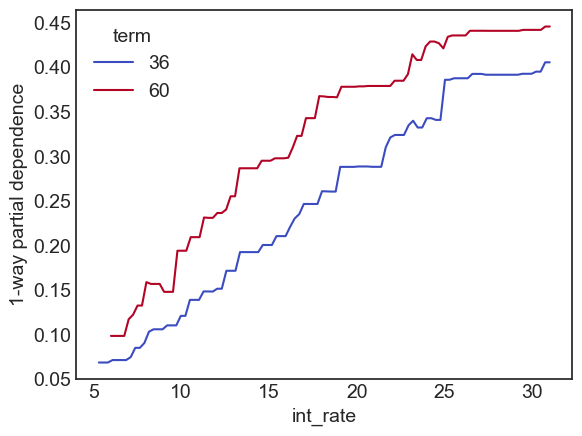

In [43]:
fig, ax = plt.subplots()

for key, group in train_samp_df.groupby('term'):
    this_pdp = partial_dependence(base_model, group[predictor_features], 
                                  ['int_rate'], kind='average',
                                 percentiles=(0,1),
                                 method='brute')
    this_pdp_df = pd.DataFrame({k:v[0] for k,v in this_pdp.items()})
    
    this_pdp_df.plot(x='values', y='average', ax=ax,
                     color=color_dict[key], label=key)
ax.set_ylabel('1-way partial dependence')
ax.set_xlabel('int_rate')
ax.legend(title='term')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_pdp_avg_double_1way.png'),
            bbox_inches='tight')

##### 2-Way ICE Curves (Sample)

In [44]:
# Get stratified samp - large sample to ensure adequate grid size
X_samp = train_samp_df[predictor_features].groupby('term').sample(100)

In [45]:
# Get 2-Way PDP
indiv_pdp = partial_dependence(base_model, X_samp, 
                                  ['int_rate', 'term'], kind='individual',
                               percentiles=(0,1),
                              method='brute',
                              grid_resolution = 100)

In [72]:
# DataFrame conversion 
num_samp = indiv_pdp['individual'][0].shape[0]
indiv_samp_df = pd.concat([pd.DataFrame(indiv_pdp['individual'][0][i,:,:],
                                   columns = indiv_pdp['values'][1]) \
                           for i in range(0, num_samp)],
                     keys = range(0, num_samp),
                     axis=1)

In [73]:
indiv_samp_df.index = pd.Series(indiv_pdp['values'][0], name='values')

In [74]:
indiv_samp_df.shape

(100, 400)

In [75]:
random.seed(43)
colsamp = random.sample(list(indiv_samp_df.columns.get_level_values(0)), 10)

In [76]:
# Get subsample of cases to make plots nicer
colsamp = random.sample(list(indiv_samp_df.columns.get_level_values(0)), 20)
indiv_samp_2_df = indiv_samp_df.loc[:, colsamp]

In [77]:
indiv_samp_2_df.shape

(100, 40)

In [78]:
# Plot - overlay term values

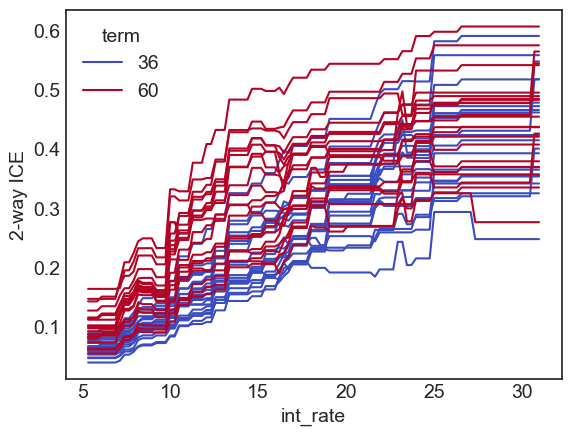

In [83]:
fig, ax = plt.subplots()

for tv in set(indiv_samp_2_df.columns.get_level_values(1)):
    this_df = indiv_samp_2_df.loc[:, indiv_samp_2_df.columns.get_level_values(1)==tv]
    this_df.plot(color=color_dict[tv],  ax=ax)
    
handles, labels = ax.get_legend_handles_labels()
labels_term = [eval(v)[1] for v in labels]
label_ind = [0] + [i for i in range(1, len(labels_term)) if labels_term[i] != labels_term[i-1]]

plt.legend([handles[i] for i in label_ind], [labels_term[i] for i in label_ind],
          title='term')
ax.set_ylabel('2-way ICE')
ax.set_xlabel('int_rate')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_ice_samples.png'),
            bbox_inches='tight')

In [ ]:
# Plot - panel, show side by side

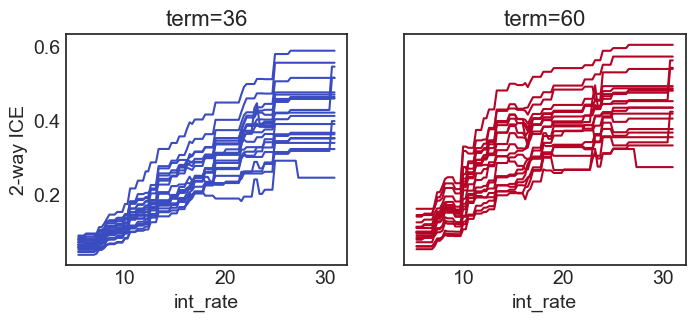

In [97]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey=True,
                      figsize = (8,3))

for i, tv in enumerate(set(indiv_samp_2_df.columns.get_level_values(1))):
    this_df = indiv_samp_2_df.loc[:, indiv_samp_2_df.columns.get_level_values(1)==tv]
    this_df.plot(color=color_dict[tv],  ax=ax[i], legend=None)
    ax[i].set_xlabel('int_rate')
    ax[i].set_title(f'term={tv}')

ax[0].set_ylabel('2-way ICE')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_ice_samples_panel.png'),
            bbox_inches='tight')

In [ ]:
TO DO
Finish ICE plots
Do the Shapley full plot
Pull out ICE samps to understand